In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import feature_column
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [9]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
real_test_df = test_df.copy()
train_df = train_df.reindex(np.random.permutation(train_df.index))
train_df = train_df[["SalePrice", "OverallCond", "MSSubClass", "LotArea"]]
test_df = test_df[["OverallCond", "MSSubClass", "LotArea"]]
print(train_df.columns)
print(test_df.columns)

Index(['SalePrice', 'OverallCond', 'MSSubClass', 'LotArea'], dtype='object')
Index(['OverallCond', 'MSSubClass', 'LotArea'], dtype='object')


In [11]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
house_style = tf.feature_column.numeric_column("MSSubClass")
feature_columns.append(house_style)

# Create a numerical feature column to represent longitude.
overall_condition = tf.feature_column.numeric_column("OverallCond")
feature_columns.append(overall_condition)

lot_area = tf.feature_column.numeric_column("LotArea")
feature_columns.append(lot_area)


# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

In [12]:
def create_model(my_learning_rate, feature_layer):
    """Create and compile a simple linear regression model."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    model.add(feature_layer)

    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

    # Construct the layers into a model that TensorFlow can execute.
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model     

def train_model(model, dataset, epochs, batch_size, label_name):

    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    print(features)
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the mean absolute error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]

    return epochs, rmse 
    

In [13]:
def plot_the_loss_curve(epochs, rmse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
    plt.show()  

2022-11-24 11:09:35.768176: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


{'OverallCond': array([6, 6, 6, ..., 5, 7, 5]), 'MSSubClass': array([90, 20, 20, ..., 20, 20, 30]), 'LotArea': array([ 6270, 17140,  7931, ...,  9100,  7200,  5825])}
Epoch 1/3000


2022-11-24 11:09:36.023350: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


15/15 [==============================] - 1s 1ms/step - loss: 21045331968.0000 - root_mean_squared_error: 145070.0938
Epoch 2/3000
15/15 [==============================] - 0s 1ms/step - loss: 19762544640.0000 - root_mean_squared_error: 140579.3125
Epoch 3/3000
15/15 [==============================] - 0s 988us/step - loss: 18041810944.0000 - root_mean_squared_error: 134319.8125
Epoch 4/3000
15/15 [==============================] - 0s 989us/step - loss: 19578970112.0000 - root_mean_squared_error: 139924.8750
Epoch 5/3000
15/15 [==============================] - 0s 929us/step - loss: 17748406272.0000 - root_mean_squared_error: 133223.1406
Epoch 6/3000
15/15 [==============================] - 0s 986us/step - loss: 19302819840.0000 - root_mean_squared_error: 138934.5938
Epoch 7/3000
15/15 [==============================] - 0s 975us/step - loss: 18220185600.0000 - root_mean_squared_error: 134982.1719
Epoch 8/3000
15/15 [==============================] - 0s 1ms/step - loss: 17792698368.0000 - 

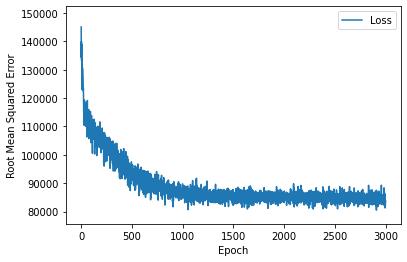


: Evaluate the new model against the test set:


In [14]:
# The following variables are the hyperparameters.
learning_rate = 2
epochs = 3000
batch_size = 100
label_name = 'SalePrice'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}

# test_label = np.array(test_features.pop(label_name))
# my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

In [15]:
def save_data(file, df):
    if (df.to_csv(file + '.csv', index = False)):
        return True
    else:
        return False

In [16]:
y = my_model.predict(test_features)
y = [j for sub in y for j in sub]
list_y = y
list_real_test = real_test_df.Id


# submit_form = pd.DataFrame(list(zip(list_real_test, list_y)),
#                           columns= ["Id", "SalePrice"])

submit_form = pd.DataFrame({
                            'Id': real_test_df['Id'],
                            'SalePrice': list_y
                        })

submit_form.head()

res = save_data('Pleum', submit_form)
# print(res)